In [1]:
import numpy as np 
import pandas as pd
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as nnf

In [2]:
NUM_CL = 19

BATCH = 16
EPOCHS = 25

LR = 0.0001
IM_SIZE = 256

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = '/kaggle/input/hpa-single-cell-image-classification/'
TRAIN_DIR = PATH + 'train/'
TEST_DIR = PATH + 'test/'

In [4]:
len(os.listdir(TEST_DIR))

2236

In [6]:
train = pd.read_csv(PATH +'train.csv')

# I take just a subset to reduce training time 
train = train[:5000]

train.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [7]:
Transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [8]:
class GetData(Dataset):
    def __init__(self, path, list_IDs, labels, img_size, Transform):
        self.path = path
        self.list_IDs = list_IDs
        self.labels = labels
        self.img_size = img_size        
        self.transform = Transform
        
    def __len__(self):
        return len(self.list_IDs)    
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]   
        
        # I take just a "green" images
        data_file = cv2.imread(self.path + ID + '_green.png')
            
        img = cv2.resize(data_file, (self.img_size, self.img_size))
        X = img/255.        
        
        if "train" in self.path:                       
            y = self.labels[index]
            y = y.split('|')
            y = list(map(int, y))            
            y = np.eye(NUM_CL, dtype='float')[y]                                    
            y = y.sum(axis=0)            
            return self.transform(X), y
        
        elif "test" in self.path:
            return self.transform(X), ID

In [9]:
X_Train, Y_Train = train['ID'].values, train['Label'].values

trainset = GetData(TRAIN_DIR, X_Train, Y_Train, IM_SIZE, Transform)
trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True)

In [10]:
X_Test = [name.rstrip('green.png').rstrip('_') for name in (os.listdir(TEST_DIR)) if '_green.png' in name]

testset = GetData(TEST_DIR, X_Test, None, IM_SIZE, Transform)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [11]:
model = torchvision.models.resnext50_32x4d()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CL)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# TRAIN

In [12]:
%%time
import time

losses = []

for epoch in range(EPOCHS):
    print('Training Epoch', epoch, "...")
    start = time.time()
    tr_loss = 0.0

    model = model.train()

    for i, (images, labels) in enumerate(trainloader):        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)       
        logits = model(images.float())  
        
        _, preds = torch.max(logits, 1)
        loss = criterion(logits, labels)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.detach().item()
    
    model.eval()
#     if i!=0:
    losses.append(tr_loss/i)
    print('Epoch: %d | Loss: %.4f'%(epoch, tr_loss/i), 'Time: {}'.format(time.time()-start))

Training Epoch 0 ...
Epoch: 0 | Loss: 0.2594 Time: 444.61944127082825
Training Epoch 1 ...
Epoch: 1 | Loss: 0.2447 Time: 344.76055002212524
Training Epoch 2 ...
Epoch: 2 | Loss: 0.2412 Time: 345.40987634658813
Training Epoch 3 ...
Epoch: 3 | Loss: 0.2368 Time: 343.8523199558258
Training Epoch 4 ...
Epoch: 4 | Loss: 0.2342 Time: 344.7979636192322
Training Epoch 5 ...
Epoch: 5 | Loss: 0.2306 Time: 345.4883646965027
Training Epoch 6 ...
Epoch: 6 | Loss: 0.2257 Time: 343.2763743400574
Training Epoch 7 ...
Epoch: 7 | Loss: 0.2207 Time: 345.4938817024231
Training Epoch 8 ...
Epoch: 8 | Loss: 0.2158 Time: 345.0962779521942
Training Epoch 9 ...
Epoch: 9 | Loss: 0.2078 Time: 347.70088243484497
Training Epoch 10 ...
Epoch: 10 | Loss: 0.2004 Time: 348.19263195991516
Training Epoch 11 ...
Epoch: 11 | Loss: 0.1897 Time: 341.6479125022888
Training Epoch 12 ...
Epoch: 12 | Loss: 0.1753 Time: 342.01021933555603
Training Epoch 13 ...
Epoch: 13 | Loss: 0.1578 Time: 345.9980297088623
Training Epoch 14 ..

In [20]:
torch.save(model, 'resnet50_25.pth')

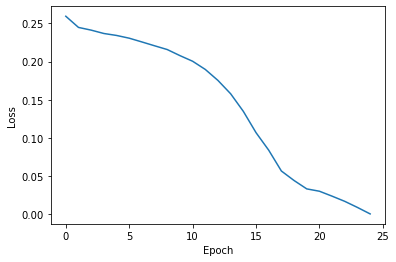

In [24]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# TEST

In [18]:
%%time

s_ls = []

with torch.no_grad():
    model.eval()
    for image, fname in testloader:     
        image = image.to(DEVICE)        
        logits = model(image.float())                          
        prob = nnf.softmax(logits, dim=1)
        p, top_class = prob.topk(1, dim=1)
        
        sp = ' '.join(str(e) for e in [top_class[0][0].item(), p[0][0].item()])               
        img = cv2.imread(TEST_DIR + fname[0] + '_green.png')
        
        if img.shape[0] == 2048:
            sp = sp + ' eNoLCAgIMAEABJkBdQ=='
        elif img.shape[0] == 1728:
            sp = sp + ' eNoLCAjJNgIABNkBkg=='
        else:
            sp = sp + ' eNoLCAgIsAQABJ4Beg=='
        print(sp)
        
        s_ls.append([fname[0], img.shape[1], img.shape[0], sp])

14 0.5026618838310242 eNoLCAjJNgIABNkBkg==
13 0.9990682005882263 eNoLCAgIMAEABJkBdQ==
12 0.3631356954574585 eNoLCAgIsAQABJ4Beg==
12 0.9914783835411072 eNoLCAgIMAEABJkBdQ==
13 0.9993026256561279 eNoLCAgIMAEABJkBdQ==
13 1.0 eNoLCAgIsAQABJ4Beg==
16 0.9609780311584473 eNoLCAgIMAEABJkBdQ==
12 0.5527949333190918 eNoLCAgIMAEABJkBdQ==
13 0.9984346032142639 eNoLCAgIMAEABJkBdQ==
13 1.0 eNoLCAgIMAEABJkBdQ==
0 0.9570439457893372 eNoLCAgIMAEABJkBdQ==
13 0.4494182765483856 eNoLCAgIMAEABJkBdQ==
14 0.7736176252365112 eNoLCAgIMAEABJkBdQ==
14 0.6481721997261047 eNoLCAgIMAEABJkBdQ==
13 0.9999998807907104 eNoLCAgIMAEABJkBdQ==
16 0.8650028109550476 eNoLCAgIMAEABJkBdQ==
13 0.9259511232376099 eNoLCAjJNgIABNkBkg==
7 0.9723911285400391 eNoLCAgIMAEABJkBdQ==
13 0.9995627999305725 eNoLCAgIMAEABJkBdQ==
13 0.9999995231628418 eNoLCAgIMAEABJkBdQ==
14 0.6231433153152466 eNoLCAgIMAEABJkBdQ==
0 0.9774904251098633 eNoLCAgIMAEABJkBdQ==
13 0.6706959009170532 eNoLCAgIMAEABJkBdQ==
14 0.6054336428642273 eNoLCAgIMAEABJkBdQ==
1

KeyboardInterrupt: 

In [16]:
sub = pd.DataFrame.from_records(s_ls, columns=['ID', 'ImageWidth', 'ImageHeight', 'PredictionString'])

print(len(sub))
sub.head()

559


,ID,ImageWidth,ImageHeight,PredictionString
0,22fa496b-f407-4df0-96ed-8942df0bcd9d,1728,1728,14 0.5026618838310242 eNoLCAjJNgIABNkBkg==
1,f6fcc0e4-95c1-4b19-ad8f-45be8fc36059,2048,2048,13 0.9990682005882263 eNoLCAgIMAEABJkBdQ==
2,ff069fa2-d948-408e-91b3-034cfea428d1,3072,3072,12 0.3631356954574585 eNoLCAgIsAQABJ4Beg==
3,ef80deae-af0d-4e3d-8b36-43adfab6c030,2048,2048,12 0.9914783835411072 eNoLCAgIMAEABJkBdQ==
4,7220d1d6-8337-4311-ac67-e612af68c90c,2048,2048,13 0.9993026256561279 eNoLCAgIMAEABJkBdQ==


In [17]:
sub.to_csv("submission.csv", index=False)